# Obtenemos los datos para trabajar

Vamos a trabajar con el Flickr8k Dataset, un dataset de imágenes con descripciones de texto. Este dataset es ideal para tareas de búsqueda semántica porque cada imagen tiene varias descripciones asociadas.

**Instalamos lo necesario**

In [14]:
# Instalar las librerías necesarias
!pip install transformers datasets sentence-transformers torch torchvision --quiet

# Crear directorio para datos
import os
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)


# Obtenemos el dataset


In [15]:
import zipfile
import requests

# URLs del dataset
images_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
captions_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

# Descargar imágenes
images_path = os.path.join(data_dir, "Flickr8k_Dataset.zip")
if not os.path.exists(images_path):
    print("Descargando imágenes...")
    response = requests.get(images_url)
    with open(images_path, "wb") as f:
        f.write(response.content)

# Descargar descripciones
captions_path = os.path.join(data_dir, "Flickr8k_text.zip")
if not os.path.exists(captions_path):
    print("Descargando descripciones...")
    response = requests.get(captions_url)
    with open(captions_path, "wb") as f:
        f.write(response.content)

# Extraer datos
with zipfile.ZipFile(images_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)
with zipfile.ZipFile(captions_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

print("Descarga y extracción completadas.")


Descarga y extracción completadas.


# Cargamos las descripciones asociadas a las imagenes.

In [16]:
import pandas as pd

# Ruta a las descripciones
captions_file = os.path.join(data_dir, "Flickr8k.token.txt")

# Leer descripciones
captions = pd.read_csv(captions_file, sep="\t", header=None, names=["image", "caption"])
captions["image"] = captions["image"].str.split("#").str[0]
captions = captions.groupby("image")["caption"].apply(list).reset_index()
captions = captions.sample(frac=0.1, random_state=42)  # Usa el 10% del dataset



# Mostrar ejemplos
print("Ejemplos de descripciones:")
print(captions.head())



Ejemplos de descripciones:
                          image  \
4194  3139876823_859c7d7c23.jpg   
4166  3133403457_95dfe11da1.jpg   
1928   244910130_e1f823a28a.jpg   
1061  2127207912_9298824e66.jpg   
736   1810651611_35aae644fb.jpg   

                                                caption  
4194  [A downhill skier in black catches a tiny bit ...  
4166  [A child wearing big green fist gloves ., A yo...  
1928  [A dark haired bearded man in glasses and a Ha...  
1061  [The two people are standing on a rock , holdi...  
736   [A closeup of a little girl on a swing ., A li...  


# Usaremos el modelo CLIP para generar embeddings tanto de imágenes como de texto.

In [17]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# Cargar el modelo y el procesador CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Función para generar embeddings
def generate_embeddings(image_path, text):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    return outputs.image_embeds, outputs.text_embeds


# Generamos embeddings para todo el dataset

In [18]:
from tqdm import tqdm
import numpy as np

# Generar y almacenar embeddings
image_embeddings = []
text_embeddings = []

images_path = os.path.join(data_dir, "Flicker8k_Dataset/")

for _, row in tqdm(captions.iterrows(), total=captions.shape[0]):
    image_path = os.path.join(images_path, row["image"])
    text = row["caption"][0]  # Usar la primera descripción
    try:
        image_embeds, text_embeds = generate_embeddings(image_path, text)
        image_embeddings.append(image_embeds.squeeze().detach().numpy())
        text_embeddings.append(text_embeds.squeeze().detach().numpy())
    except Exception as e:
        print(f"Error procesando {row['image']}: {e}")

# Convertir a matrices numpy
image_embeddings = np.array(image_embeddings)
text_embeddings = np.array(text_embeddings)

print("Embeddings generados.")


 62%|██████▏   | 505/809 [02:40<01:26,  3.51it/s]

Error procesando 2258277193_586949ec62.jpg.1: [Errno 2] No such file or directory: '/content/data/Flicker8k_Dataset/2258277193_586949ec62.jpg.1'


100%|██████████| 809/809 [04:15<00:00,  3.16it/s]

Embeddings generados.


# Guardamos los embeddings

In [19]:
# Guardar embeddings
np.save(os.path.join(data_dir, "image_embeddings.npy"), image_embeddings)
np.save(os.path.join(data_dir, "text_embeddings.npy"), text_embeddings)

print("Embeddings guardados.")


Embeddings guardados.


# Usaremos estos embeddings para implementar un buscador basado en similitud de coseno.

**Primero, cargamos los embeddings previamente guardados y las rutas de las imágenes.**

In [23]:
import numpy as np
import os

# Ruta de los embeddings y directorio de imágenes
data_dir = "data"
image_embeddings_path = os.path.join(data_dir, "image_embeddings.npy")
text_embeddings_path = os.path.join(data_dir, "text_embeddings.npy")
images_dir = os.path.join(data_dir, "Flicker8k_Dataset/")

# Cargar embeddings
image_embeddings = np.load(image_embeddings_path)
text_embeddings = np.load(text_embeddings_path)

# Cargar nombres de las imágenes
captions_file = os.path.join(data_dir, "Flickr8k.token.txt")
captions = pd.read_csv(captions_file, sep="\t", header=None, names=["image", "caption"])
captions["image"] = captions["image"].str.split("#").str[0]
unique_images = captions["image"].unique()

print(f"Embeddings cargados. Total de imágenes: {len(unique_images)}")


Embeddings cargados. Total de imágenes: 8092


** Implementamos la búsqueda por simulitud de coseno**

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.pyplot as plt

# Función para realizar la búsqueda
def search_similar_images(query, top_k=5):
    # Generar embedding para el texto de consulta
    inputs = processor(text=[query], return_tensors="pt", padding=True)
    text_embed = model.get_text_features(**inputs)
    text_embed = text_embed / text_embed.norm(dim=-1, keepdim=True)

    # Calcular similitud de coseno con los embeddings de las imágenes
    similarities = cosine_similarity(text_embed.detach().numpy(), image_embeddings)[0]

    # Obtener los índices de las imágenes más similares
    top_indices = similarities.argsort()[-top_k:][::-1]
    top_images = [unique_images[idx] for idx in top_indices]
    top_scores = [similarities[idx] for idx in top_indices]

    # Mostrar las imágenes más similares
    print(f"Búsqueda para: '{query}'")
    for i, (img_name, score) in enumerate(zip(top_images, top_scores)):
        img_path = os.path.join(images_dir, img_name)
        image = Image.open(img_path)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Similitud: {score:.4f}")
        plt.show()


**Probamos el modelo**

Búsqueda para: 'a kid playin in the street'


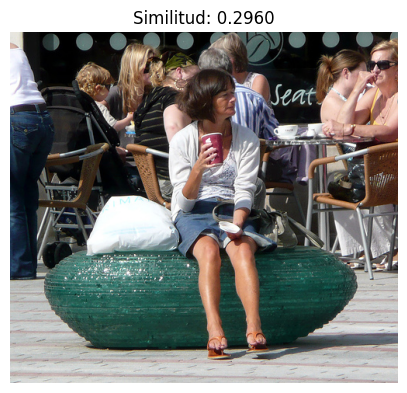

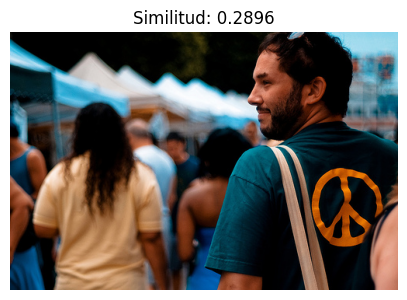

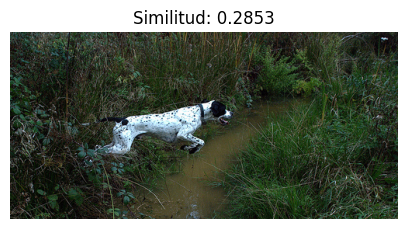

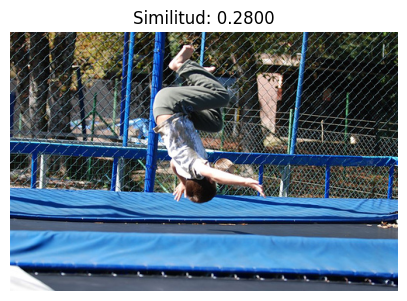

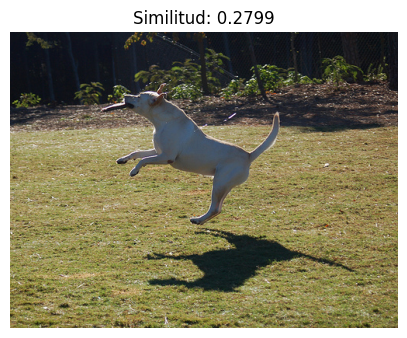

In [30]:
# Prueba de búsqueda semántica
query_text = "a kid playin in the street"
search_similar_images(query_text, top_k=5)
